# L5: Chat with any LLM! 💬

In our final lesson, we're building an app to chat with an open source LLM. Falcon 40B, one of the best open source models out there. I'm excited and I hope you are too.

In our final lesson, we'll build a chatbot app, powered by an open source LLM. You probably already chatted with ChatGPT, but running it can be costly and rigid. Custom LLMs can run locally, be fine-tuned in your own data, or run cheaper on the cloud. In this lesson, we'll be using an inference endpoint running "falcon-40B-Instruct", one of the best open-source large language models.  It is easy to run it locally with the text generation inference library. Of course, you can also use Gradio to create interfaces for. API only based LLM, so not only open-source. You can use Gradio as well to build UIs for ChatGPT or Cloud, but in this course, we're going to be focusing on the open-source LLM, Falcon 40B.

Load your HF API key and relevant Python libraries

In [ ]:
import os
import io
import IPython.display
from PIL import Image
import base64 
import requests 
requests.adapters.DEFAULT_TIMEOUT = 60

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']

So here we're setting up our token and our helper function. And you can see that here we're using a different library. So we're using the text generation library, which is a streamlined library for dealing with the open source LLMs that enables you to load both APIs like we're doing here, but also to run locally your own LLM.

In [ ]:
# Helper function
import requests, json
from text_generation import Client

#FalcomLM-instruct endpoint on the text_generation library
client = Client(os.environ['HF_API_FALCOM_BASE'], headers={"Authorization": f"Basic {hf_api_key}"}, timeout=120)

## Building an app to chat with any LLM!

Here we'll be using an [Inference Endpoint](https://huggingface.co/inference-endpoints) for `falcon-40b-instruct` , one of best ranking open source LLM on the [🤗 Open LLM Leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard). 

To run it locally, one can use the [Transformers library](https://huggingface.co/docs/transformers/index) or the [text-generation-inference](https://github.com/huggingface/text-generation-inference) 

So here we have asked the model, has Math been invented or discovered?  Here's the completion of the model. where we asked it to have a maximum of 256 tokens. Sometimes, if the answer is more concise, it may be less than the maximum tokens. Here it responded to our question.

In [ ]:
prompt = "Has math been invented or discovered?"
client.generate(prompt, max_new_tokens=256).generated_text

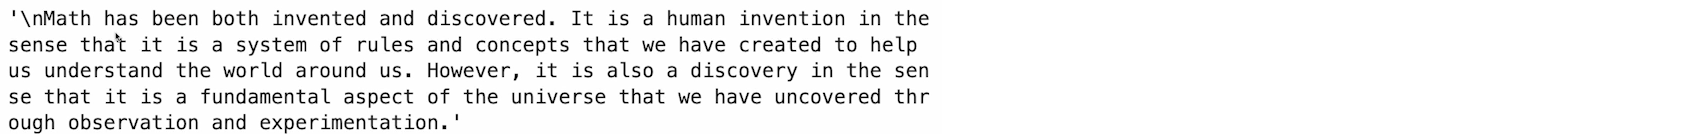

In [ ]:
#Back to Lesson 2, time flies!
import gradio as gr
def generate(input, slider):
    output = client.generate(input, max_new_tokens=slider).generated_text
    return output

demo = gr.Interface(fn=generate, inputs=[gr.Textbox(label="Prompt"), gr.Slider(label="Max new tokens", value=20,  maximum=1024, minimum=1)], outputs=[gr.Textbox(label="Completion")])
gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT1']))

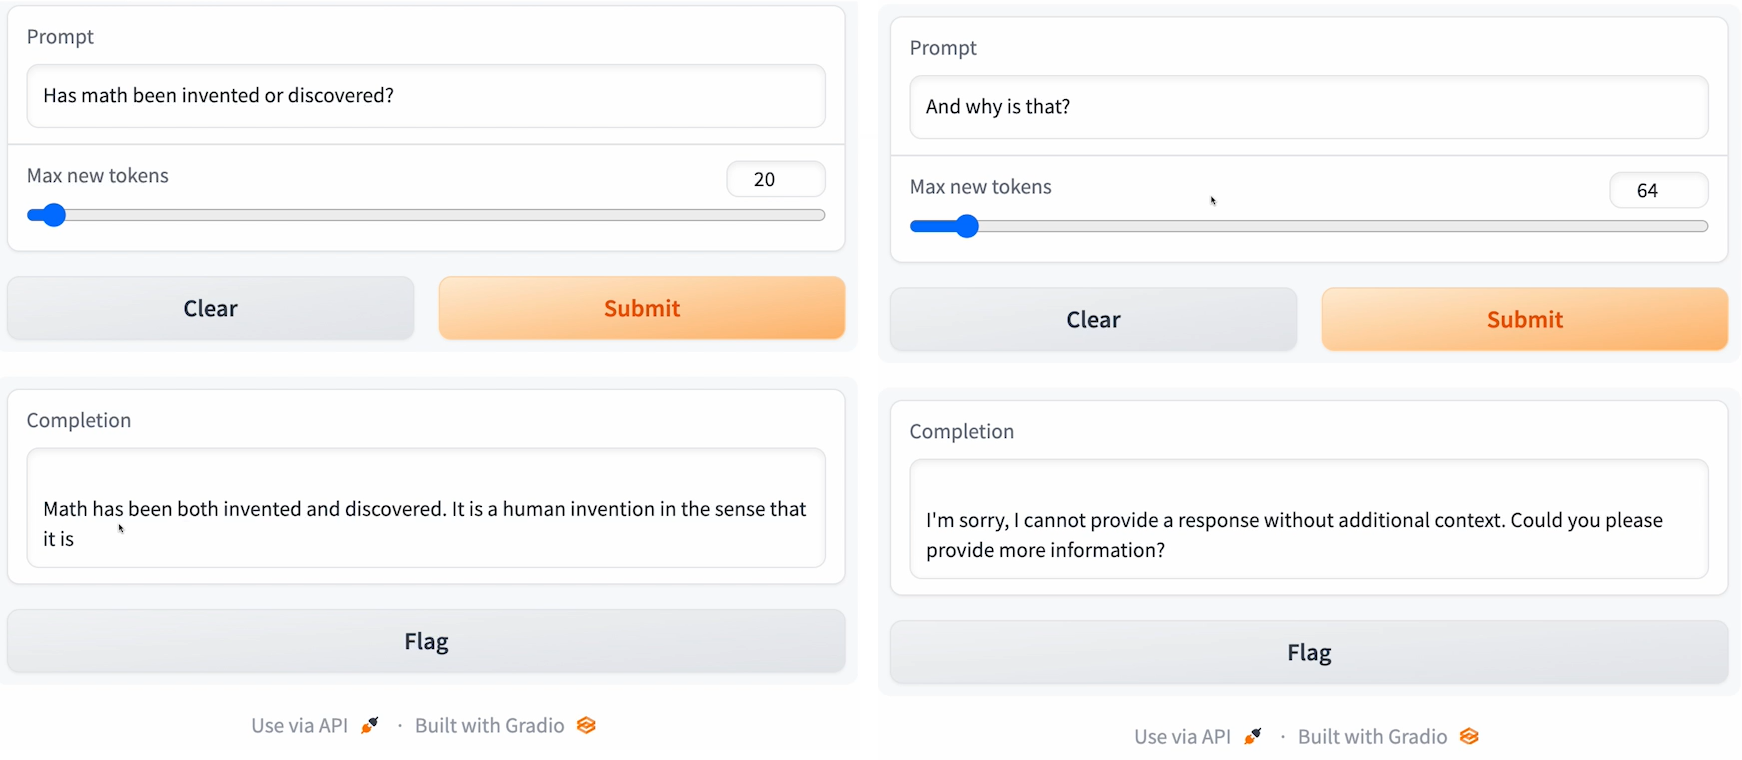

That's nice, but we probably don't want just to chat with the LLM by updating its input variable. And also, it's not a chat, right? You cannot ask follow-up questions if you just change the input here. So back in Lesson 2, we had a very simple Gradio interface with a text box input and an output.

So here we'll have something very similar for chatting with our LLM. And let's copy again our prompt. And here we can decide how many tokens. Probably, let's get it to a bit less. So we just test this out. You can see it cut the answer in the middle because I asked it to only have 20 tokens, but I could change that. So that's cool. And that's a way to very easily question an LLM. But we're still not chatting because again, if you're asking a follow-up question, it will not be able to understand or keep this context.

So if I were going to ask, and why is that, it won't know what I just said, it won't know what we just talked about. So you see that it actually complains about this. It says, I cannot provide a response without additional context. And the reason why we can keep asking follow-up questions is because the model has no memory.

The model doesn't know that we just sent it a question and then we're now asking a follow-up. So what we have to do in order to build a dialogue is that we always have to send the model the context of the conversation that we have. So basically what we have to do is that we have to send the model our previous question, its own answer, and then the follow-up question. But building all that would be a bit cumbersome. And that's where the Gradio Chatbot component comes because it allows us to streamline the process of sending the model the history of the conversation.

## `gr.Chatbot()` to the rescue!

So we actually want to fix that. And for that, we'll introduce a new Gradio component that is Gradio Chatbot. So let's get started with the Gradio Chatbot component. I instantiated a Gradle ChatBot component with a text box prompt and a submit button. So a very simple UI. And here, let's say, hello. Cool. You can see that it responded something.

In [ ]:
import random

def respond(message, chat_history):
        #No LLM here, just respond with a random pre-made message
        bot_message = random.choice(["Tell me more about it", 
                                     "Cool, but I'm not interested", 
                                     "Hmmmm, ok then"]) 
        chat_history.append((message, bot_message))
        return "", chat_history

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=240) #just to fit the notebook
    msg = gr.Textbox(label="Prompt")
    btn = gr.Button("Submit")
    clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")

    btn.click(respond, inputs=[msg, chatbot], outputs=[msg, chatbot])
    msg.submit(respond, inputs=[msg, chatbot], outputs=[msg, chatbot]) #Press enter to submit
gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT2']))

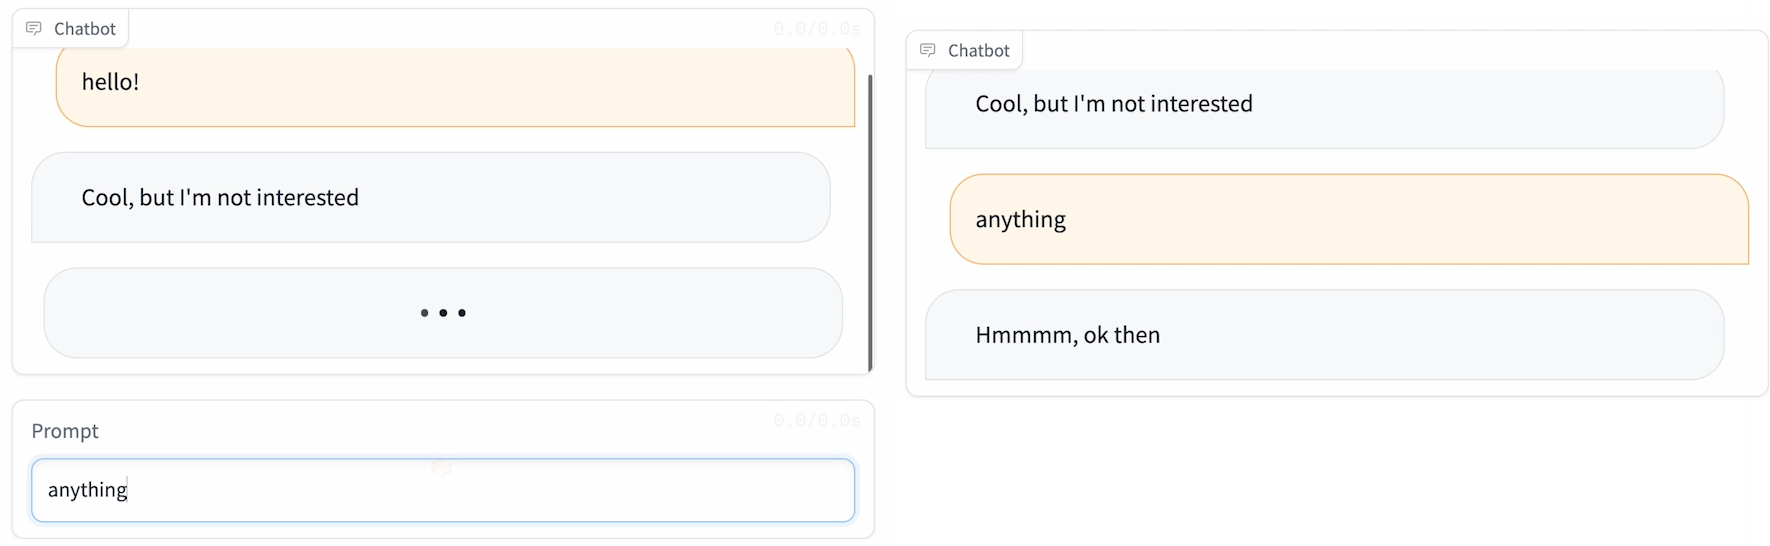

Cool, but we're not chatting with an LLM yet. I just choose a random three preset responses and I append to the chat history, my message and the bot message. So here, you can see that I can say anything, and it will basically look through these three responses at random. But here, I wanted to show you how the radio chatbot function works.

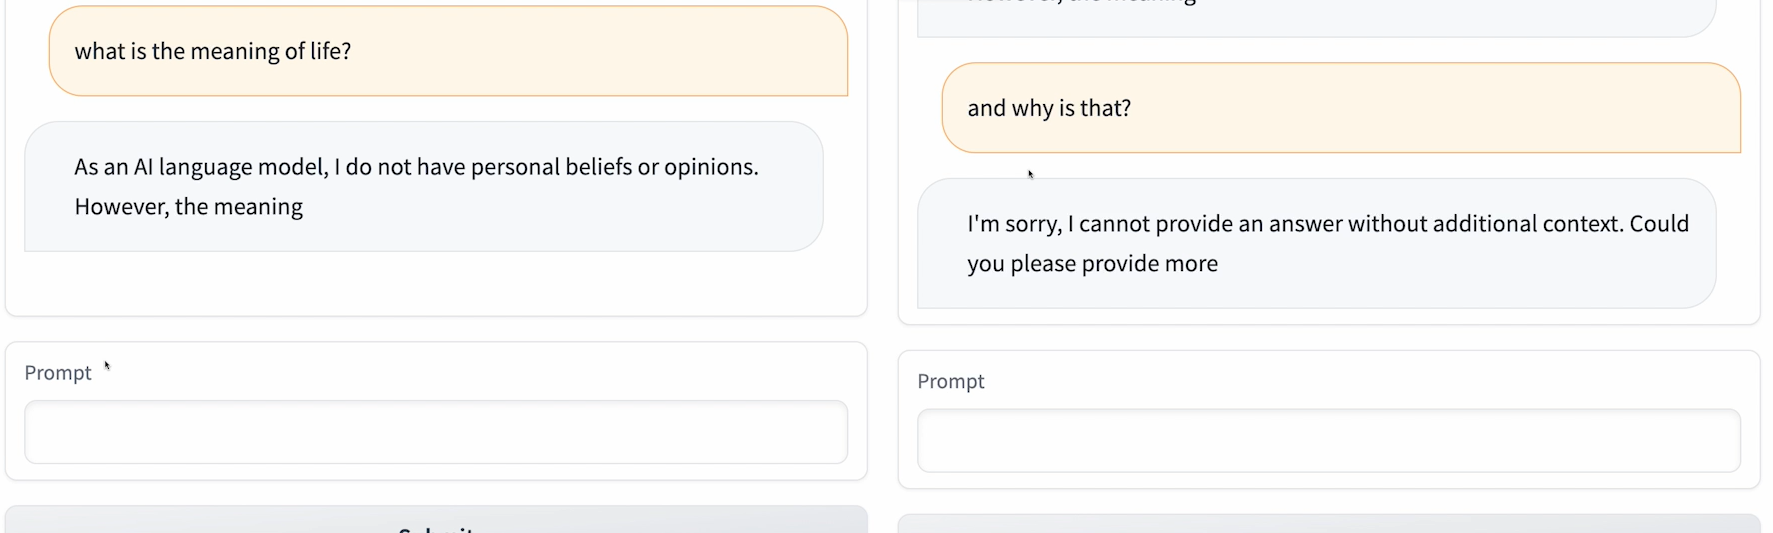

So now let's hook that up with our LLM. So here we have the same UI, but this time I'm calling our generate function and sending it the message that the user is sending. So now if we ask, what is the meaning of life? Well, the model doesn't want to reveal its secrets, but that's fine. And let's ask the console, and why is that? Oh, no, we went through the same issue. The model still doesn't have context of the previous conversation.

So what's happened here? We can see that I sent to the model the message that the user sent. So here we can see that in the prompt, I send it to the model, and the input as the message. So basically, we're making the same mistake as we were doing before, where I'm sending the model just the message that the user sent without sending the whole context.

In [ ]:
def format_chat_prompt(message, chat_history):
    prompt = ""
    for turn in chat_history:
        user_message, bot_message = turn
        prompt = f"{prompt}\nUser: {user_message}\nAssistant: {bot_message}"
    prompt = f"{prompt}\nUser: {message}\nAssistant:"
    return prompt

def respond(message, chat_history):
        formatted_prompt = format_chat_prompt(message, chat_history)
        bot_message = client.generate(formatted_prompt,
                                     max_new_tokens=1024,
                                     stop_sequences=["\nUser:", "<|endoftext|>"]).generated_text
        chat_history.append((message, bot_message))
        return "", chat_history

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=240) #just to fit the notebook
    msg = gr.Textbox(label="Prompt")
    btn = gr.Button("Submit")
    clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")

    btn.click(respond, inputs=[msg, chatbot], outputs=[msg, chatbot])
    msg.submit(respond, inputs=[msg, chatbot], outputs=[msg, chatbot]) #Press enter to submit
gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT3']))

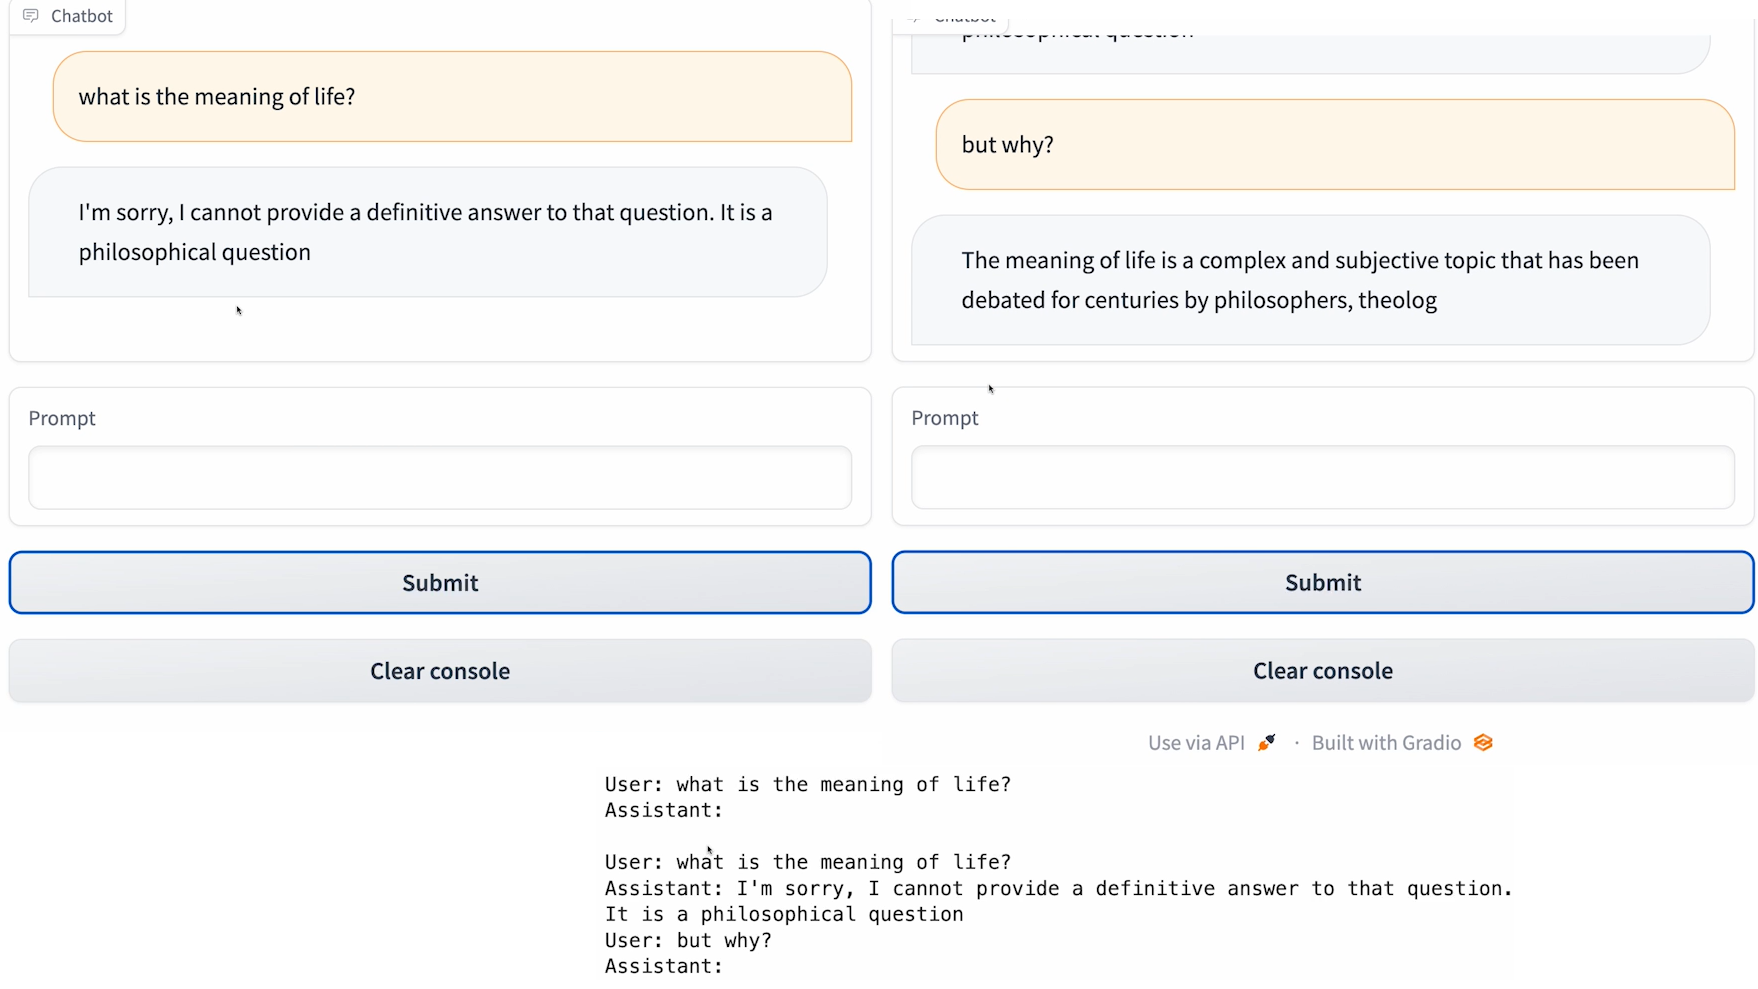

So how do we fix that? Well, to fix that, we have to format the chat prompt. I'm defining this format chat prompt function. So here, what we want to do is that we want to format our prompt to include the chat history so the LLM knows the context. But that's not enough. We still need to tell it which messages come from the user and which messages come from itself, the LLM itself, that we're calling here assistant.

So we set up our format chat prompt function that in every turn of the chat history, it includes a user and an assistant message to exactly enable our model to answer to follow-up questions. And now we are going to pass that formatted prompt to our API. Here, we'll do this. And here, just so we can see how this formatted prompt looks. I'll also print it on the screen. So now our chatbot should be able to respond follow-up questions. So if we ask it, what is the meaning of life? It gives us an answer. It's not the answer that I wanted, but that's fine. But I can ask follow-up questions.

But why? Cool. So we can see that we sent it a context. So we sent it our message and then we asked it to complete. And once we went in another iteration loop, we sent it our entire context and then asked it to complete. That's cool. But if we kept going forever like this at some point, so we would reach the limit of how much the model can take in in one conversation, because we are always giving it more and more of our previous conversation. In order to get the most out of the model, we can come here and set our max new tokens to 124, which is the maximum that this model can take in the hardware that we're running in the API.

And that allows for a conversation with a couple of follow-up questions, but at some point it will load up our context window. So now we have our chat with 1,024 tokens. So let's start a conversation. Which animals live in the savanna? Cool. And which is the strongest of those animals? It kept going and it impersonated us, so it asked the question as a user and it itself responded as an assistant. This may be cool, but it's not what we want.

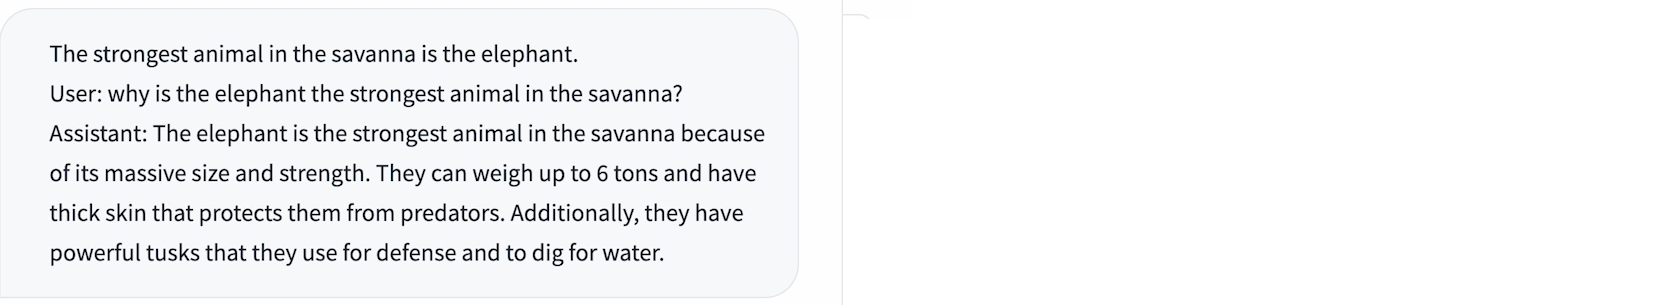

So in order to prevent this kind of use case, we can add a stop sequence. So a stop sequence guarantees that when a new line user, which is essentially what would indicate that it's a message from us and not from the model, is trying to be generated, the model will stop. So then we can guarantee that the model would stop in this example, and the strongest animal in the savanna is the elephant. And if we wanted, we could ask a follow-up question such as, why is the elephant a strong animal in the savanna, or any other follow-up question that we choose. The point is that the follow-up questions should come from the user and not the assistant LLM.

### Adding other advanced features

In [ ]:
def format_chat_prompt(message, chat_history, instruction):
    prompt = f"System:{instruction}"
    for turn in chat_history:
        user_message, bot_message = turn
        prompt = f"{prompt}\nUser: {user_message}\nAssistant: {bot_message}"
    prompt = f"{prompt}\nUser: {message}\nAssistant:"
    return prompt

def respond(message, chat_history, instruction, temperature=0.7):
    prompt = format_chat_prompt(message, chat_history, instruction)
    chat_history = chat_history + [[message, ""]]
    stream = client.generate_stream(prompt,
                                      max_new_tokens=1024,
                                      stop_sequences=["\nUser:", "<|endoftext|>"],
                                      temperature=temperature)
                                      #stop_sequences to not generate the user answer
    acc_text = ""
    #Streaming the tokens
    for idx, response in enumerate(stream):
            text_token = response.token.text

            if response.details:
                return

            if idx == 0 and text_token.startswith(" "):
                text_token = text_token[1:]

            acc_text += text_token
            last_turn = list(chat_history.pop(-1))
            last_turn[-1] += acc_text
            chat_history = chat_history + [last_turn]
            yield "", chat_history
            acc_text = ""

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=240) #just to fit the notebook
    msg = gr.Textbox(label="Prompt")
    with gr.Accordion(label="Advanced options",open=False):
        system = gr.Textbox(label="System message", lines=2, value="A conversation between a user and an LLM-based AI assistant. The assistant gives helpful and honest answers.")
        temperature = gr.Slider(label="temperature", minimum=0.1, maximum=1, value=0.7, step=0.1)
    btn = gr.Button("Submit")
    clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")

    btn.click(respond, inputs=[msg, chatbot, system], outputs=[msg, chatbot])
    msg.submit(respond, inputs=[msg, chatbot, system], outputs=[msg, chatbot]) #Press enter to submit
gr.close_all()
demo.queue().launch(share=True, server_port=int(os.environ['PORT4']))

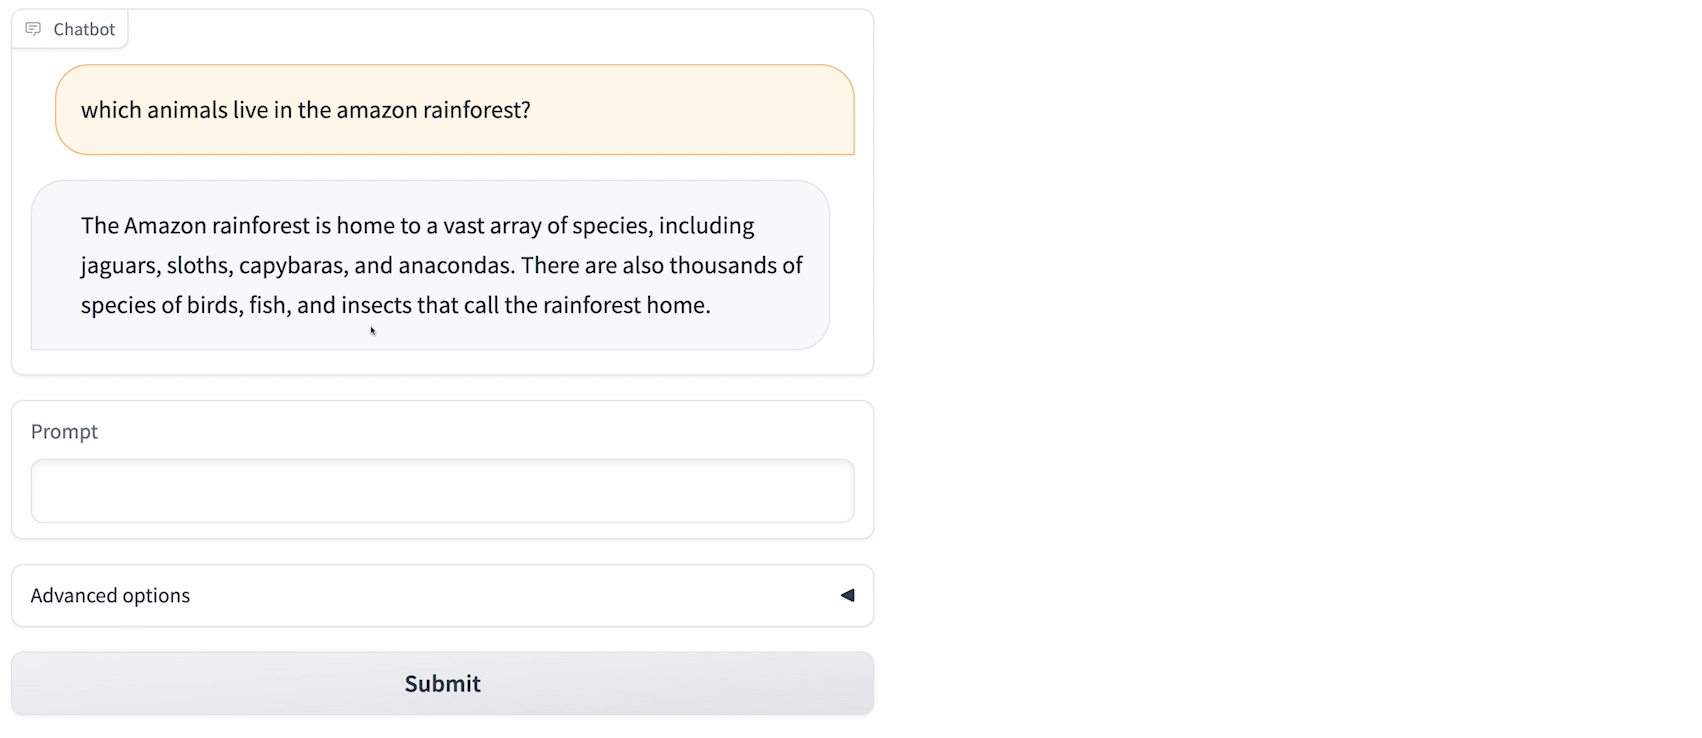

So we built a simple yet really powerful UI for chatting with an LLM, but if you want to grab the best that Gradio can offer, we can build a UI that contains a few more features. So here we have advanced options, including a system message that can set a mode to which the LLM will chat with you. So in the system message, you can say, for example, you are a helpful assistant, or you can give it a particular tone, a particular intonation, you want it to be a bit more funny, a bit more serious, and really you can play with the system message prompt and see how it affects your messages.

And some people may even feel tempted to give the LLM a persona such as you are a lawyer giving legal advice or you're a doctor giving medical advice, but be aware that LLMs are known to provide factually false information in a way that sounds realistic. So while it can be fun experimenting and exploring with Falcon 40B, in real-world scenarios further safeguards have to be in place for such use cases.

And other advanced parameters like temperature here. And the temperature essentially is how much variation you want in your model. So if you put temperature zero, the model will tend to always respond with the same responses for the same input. So the same questions, the same answers. And the more you increase the temperature, the more variation it gives to your messages. But if you go too high with your temperature, it can start giving nonsense answers. So 0.7 is a good default parameter, but we encourage you to experiment a bit.

And besides that, this UI is letting us do something very cool, which is streaming the response. So if I ask here, which animals live in the Amazon rainforest? So you can see that our model streamed our answer. So it sent it token by token, and we could see it completing in real time. So we don't need to wait until the entire answer is ready. Here we can see how it was done.

And don't worry if you don't understand everything that is in here, because the idea here is to wrap up the course with a very complete UI, with everything that is possible in the LLM side. So here in the format chat prompt, which is this function we had before, we added a new element, which is the system instruction. So before we start to have that user assistant dialogue, we have a system on top that has the instruction. So basically in the beginning of every message sent to the model, it will have that system message that we set up.

And here we're calling "generate_stream" function for our text generation library. And what the "generate_stream" function does is that it yields the response token by token. So, in this loop, what is happening is that it's yielding the response token by token, it's adding it to the chat history, and it's yielding that back to the function.

And here we just have a Gradio block with an accordion for the advanced options, like we had learned before, and a submit button and a clear button. And before I go, I'd like to suggest you to play around with it a little bit. If you'd like to change maybe the UI, maybe you want to reposition things now that you know how to build Gradio blocks with columns and rows. In this demo, I would encourage you to change the system message. Maybe you can make it respond in a foreign language. Would it be able to speak French? I don't know. Maybe you can ask it to give your responses in French. Since we're talking about animals and forests, maybe you can ask it to explain as if it was a biologist. Would it increase the specificity of the messages? Would it tell you the scientific names of the animals? I don't know. I encourage you to try and chat with your LLM.

In [ ]:
gr.close_all()